100%|██████████| 83.7M/83.7M [00:00<00:00, 252MB/s]


Enter the image URL: https://i.pinimg.com/564x/b8/8c/7c/b88c7c29d2da22ef603e409bd5afeeec.jpg

0: 640x480 1 person, 1 tie, 3244.8ms
Speed: 16.8ms preprocess, 3244.8ms inference, 32.7ms postprocess per image at shape (1, 3, 640, 480)
Model Inference Time: 7.1715 seconds
Enter the red value (0-255): 255
Enter the green value (0-255): 0
Enter the blue value (0-255): 0
Enter a key to store the RGB values: Kishore
RGB values for key 'Kishore' saved successfully to key_rgb_values.json


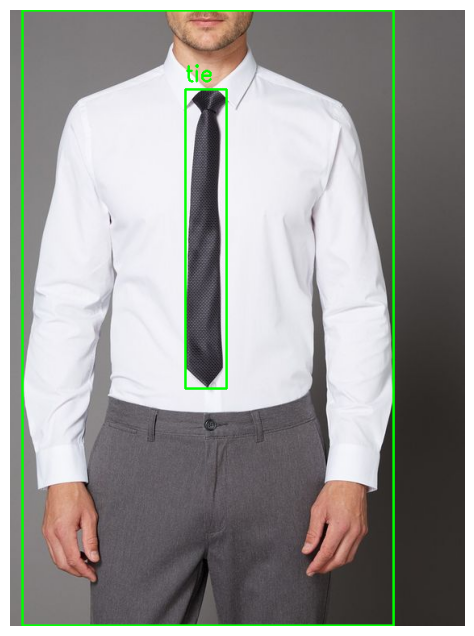

Select the tag to color from the detected objects {'person', 'tie'}: tie


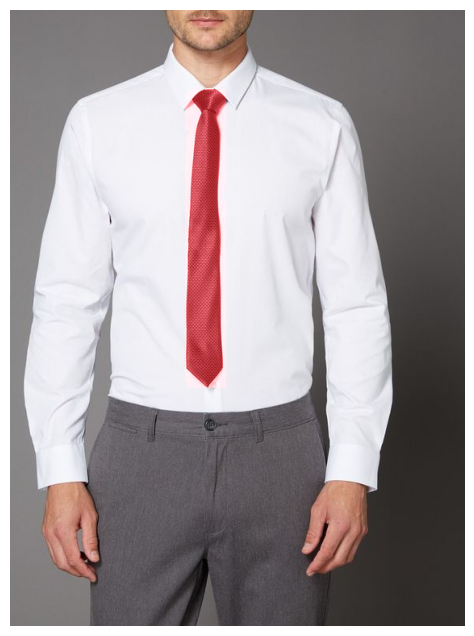

Output image saved as output_image.jpg
Processing Time: 0.3936 seconds
Total Execution Time: 38.7390 seconds


In [3]:
import time
from ultralytics import YOLO
import cv2
import numpy as np
from matplotlib import pyplot as plt
from urllib.request import urlretrieve
import json


startTime = time.time()

# Load the YOLOv8 model
model = YOLO('yolov8l.pt')

# Get the URL of the Image
inputImage_url = input("Enter the image URL: ")
inputImage_path = 'input_image.jpg'
urlretrieve(inputImage_url, inputImage_path)

# Read the input image with OpenCV
image = cv2.imread(inputImage_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform inference
inference_start = time.time()
results = model.predict(image_rgb)
inference_end = time.time()
inference_duration = inference_end - inference_start
print(f"Model Inference Time: {inference_duration:.4f} seconds")

# Get the RGB Values to be filled
r_value = int(input("Enter the red value (0-255): "))
g_value = int(input("Enter the green value (0-255): "))
b_value = int(input("Enter the blue value (0-255): "))

# Ask for a key to store the RGB values
rgb_key = input("Enter a key to store the RGB values: ")

# Define a function to save RGB values to a local file
def save_rgb_to_file(key, r, g, b, filename='key_rgb_values.json'):
    rgb_data = {}

    # Try to read the existing data, if the file exists
    try:
        with open(filename, 'r') as file:
            rgb_data = json.load(file)
    except FileNotFoundError:
        pass

    # Store the new RGB values against the key
    rgb_data[key] = {'red': r, 'green': g, 'blue': b}

    # Write the updated data back to the file
    with open(filename, 'w') as file:
        json.dump(rgb_data, file, indent=4)

    print(f"RGB values for key '{key}' saved successfully to {filename}")

# Save the RGB values to a file
save_rgb_to_file(rgb_key, r_value, g_value, b_value)

# Define the function to fill the area with a custom color using Sobel edge detection
def fill_area_with_custom_color(crop, b_value, g_value, r_value):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Sobel edge detection
    sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)  # Sobel in x-direction
    sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)  # Sobel in y-direction

    # Combine the x and y direction Sobel results
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)
    sobel_combined = np.uint8(np.absolute(sobel_combined))  # Convert to uint8

    # Threshold the result to get a binary edge map
    _, edges = cv2.threshold(sobel_combined, 50, 255, cv2.THRESH_BINARY)

    # Dilate the edges to close small gaps
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=2)

    # Find contours from the dilated edges
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the contours
    mask = np.zeros(crop.shape[:2], dtype=np.uint8)

    # Fill the contours with white on the mask
    for contour in contours:
        if cv2.contourArea(contour) > 1000:
            cv2.drawContours(mask, [contour], 0, 255, -1)

    # Create a custom color overlay based on user input
    custom_overlay = np.zeros_like(crop)
    custom_overlay[:] = (b_value, g_value, r_value)  # BGR color format

    # Apply the mask to the custom color overlay
    custom_filled_area = cv2.bitwise_and(custom_overlay, custom_overlay, mask=mask)

    # Combine the original image with the custom filled area
    result = cv2.addWeighted(crop, 1, custom_filled_area, 0.5, 0)

    return result

# Creating a copy of the original image
final_image = image.copy()

# Display detected objects and store class names for user input
class_names_detected = []
for result in results:
    for box in result.boxes:
        class_name = result.names[int(box.cls)]
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        class_names_detected.append(class_name)

        # Draw bounding box (green) and put class name on the display image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with bounding boxes and class tags
image_rgb_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb_display)
plt.axis('off')
plt.show()

# Add a 5-second delay before asking for the object to be selected, This is because the plt.show is taking some time to display the image
time.sleep(5)

#  Ask the user to select the tag after displaying the image
selected_tag = input(f"Select the tag to color from the detected objects {set(class_names_detected)}: ")

# Process detected objects again to fill selected area
processing_start = time.time()
for result in results:
    for box in result.boxes:
        class_name = result.names[int(box.cls)]
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        if class_name.lower() == selected_tag.lower():
            # Crop the detected region from the final image (without boxes)
            crop = final_image[y1:y2, x1:x2]

            # Fill the area with custom color using Canny detector
            filled_crop = fill_area_with_custom_color(crop, b_value, g_value, r_value)

            # Replace the cropped region in the final image (without boxes)
            final_image[y1:y2, x1:x2] = filled_crop

# Convert to RGB for displaying with matplotlib
final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

# Display the final image with the filled area and no bounding boxes or tags
plt.figure(figsize=(12, 8))
plt.imshow(final_image_rgb)
plt.axis('off')
plt.show()

# Save the output image without green boxes and labels
output_image_path = 'output_image.jpg'
cv2.imwrite(output_image_path, final_image)

processing_end = time.time()
processing_duration = processing_end - processing_start
total_duration = time.time() - startTime

# Print performance results
print(f"Output image saved as {output_image_path}")
print(f"Processing Time: {processing_duration:.4f} seconds")
print(f"Total Execution Time: {total_duration:.4f} seconds")


In [2]:
pip install ultralytics opencv-python matplotlib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 691.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.8/871.8 kB 16.5 MB/s eta 0:00:00


Enter the image URL: https://i.pinimg.com/564x/b8/8c/7c/b88c7c29d2da22ef603e409bd5afeeec.jpg

0: 640x480 1 person, 1 tie, 2316.0ms
Speed: 7.1ms preprocess, 2316.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)
Model Inference Time: 5.1592 seconds
Enter the red value (0-255): 154
Enter the green value (0-255): 0
Enter the blue value (0-255): 111
Enter a key to store the RGB values: Kisore
RGB values for key 'Kisore' saved successfully to key_rgb_values.json


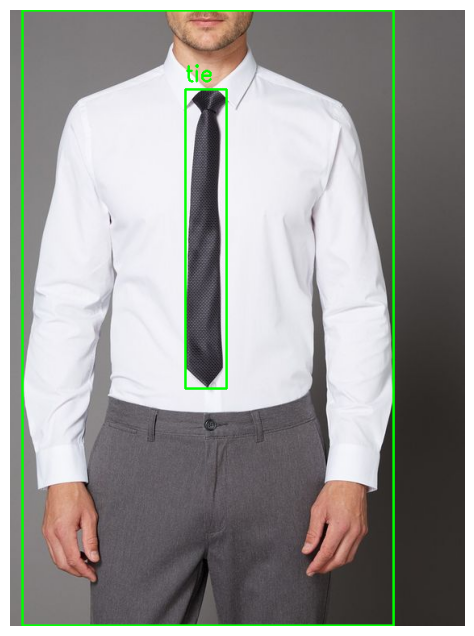

Select the tag to color from the detected objects {'person', 'tie'}: tie


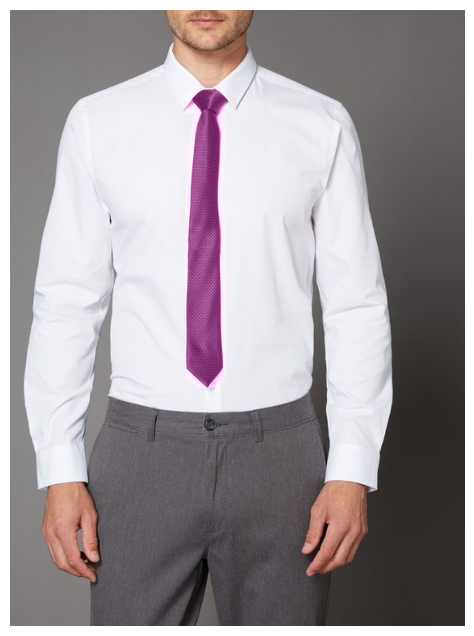

Output image saved as output_image.jpg
Processing Time: 0.2642 seconds
Total Execution Time: 32.5605 seconds


In [6]:
import time
from ultralytics import YOLO
import cv2
import numpy as np
from matplotlib import pyplot as plt
from urllib.request import urlretrieve
import json


startTime = time.time()

# Load the YOLOv8 model
model = YOLO('yolov8l.pt')

# Get the URL of the Image
inputImage_url = input("Enter the image URL: ")
inputImage_path = 'input_image.jpg'
urlretrieve(inputImage_url, inputImage_path)

# Read the input image with OpenCV
image = cv2.imread(inputImage_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform inference
inference_start = time.time()
results = model.predict(image_rgb)
inference_end = time.time()
inference_duration = inference_end - inference_start
print(f"Model Inference Time: {inference_duration:.4f} seconds")

# Get the RGB Values to be filled
r_value = int(input("Enter the red value (0-255): "))
g_value = int(input("Enter the green value (0-255): "))
b_value = int(input("Enter the blue value (0-255): "))

# Ask for a key to store the RGB values
rgb_key = input("Enter a key to store the RGB values: ")

# Define a function to save RGB values to a local file
def save_rgb_to_file(key, r, g, b, filename='key_rgb_values.json'):
    rgb_data = {}

    # Try to read the existing data, if the file exists
    try:
        with open(filename, 'r') as file:
            rgb_data = json.load(file)
    except FileNotFoundError:
        pass

    # Store the new RGB values against the key
    rgb_data[key] = {'red': r, 'green': g, 'blue': b}

    # Write the updated data back to the file
    with open(filename, 'w') as file:
        json.dump(rgb_data, file, indent=4)

    print(f"RGB values for key '{key}' saved successfully to {filename}")

# Save the RGB values to a file
save_rgb_to_file(rgb_key, r_value, g_value, b_value)

# Define the function to fill the area with a custom color using Prewitt edge detection

def fill_area_with_custom_color(crop, b_value, g_value, r_value):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Prewitt edge detection
    kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=np.float64)  # Prewitt in x-direction
    kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=np.float64)  # Prewitt in y-direction

    prewitt_x = cv2.filter2D(blurred, cv2.CV_64F, kernel_x)  # Apply Prewitt filter in x-direction
    prewitt_y = cv2.filter2D(blurred, cv2.CV_64F, kernel_y)  # Apply Prewitt filter in y-direction

    # Combine the x and y direction Prewitt results
    prewitt_combined = np.sqrt(prewitt_x**2 + prewitt_y**2)
    prewitt_combined = np.uint8(np.absolute(prewitt_combined))  # Convert to uint8

    # Threshold the result to get a binary edge map
    _, edges = cv2.threshold(prewitt_combined, 50, 255, cv2.THRESH_BINARY)

    # Dilate the edges to close small gaps
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=2)

    # Find contours from the dilated edges
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the contours
    mask = np.zeros(crop.shape[:2], dtype=np.uint8)

    # Fill the contours with white on the mask
    for contour in contours:
        if cv2.contourArea(contour) > 1000:
            cv2.drawContours(mask, [contour], 0, 255, -1)

    # Create a custom color overlay based on user input
    custom_overlay = np.zeros_like(crop)
    custom_overlay[:] = (b_value, g_value, r_value)  # BGR color format

    # Apply the mask to the custom color overlay
    custom_filled_area = cv2.bitwise_and(custom_overlay, custom_overlay, mask=mask)

    # Combine the original image with the custom filled area
    result = cv2.addWeighted(crop, 1, custom_filled_area, 0.5, 0)

    return result


# Creating a copy of the original image
final_image = image.copy()

# Display detected objects and store class names for user input
class_names_detected = []
for result in results:
    for box in result.boxes:
        class_name = result.names[int(box.cls)]
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        class_names_detected.append(class_name)

        # Draw bounding box (green) and put class name on the display image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with bounding boxes and class tags
image_rgb_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb_display)
plt.axis('off')
plt.show()

# Add a 5-second delay before asking for the object to be selected
time.sleep(5)

#  Ask the user to select the tag after displaying the image
selected_tag = input(f"Select the tag to color from the detected objects {set(class_names_detected)}: ")

# Process detected objects again to fill selected area
processing_start = time.time()
for result in results:
    for box in result.boxes:
        class_name = result.names[int(box.cls)]
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        if class_name.lower() == selected_tag.lower():
            # Crop the detected region from the final image (without boxes)
            crop = final_image[y1:y2, x1:x2]

            # Fill the area with custom color using Prewitt detector
            filled_crop = fill_area_with_custom_color(crop, b_value, g_value, r_value)

            # Replace the cropped region in the final image (without boxes)
            final_image[y1:y2, x1:x2] = filled_crop

# Convert to RGB for displaying with matplotlib
final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

# Display the final image with the filled area and no bounding boxes or tags
plt.figure(figsize=(12, 8))
plt.imshow(final_image_rgb)
plt.axis('off')
plt.show()

# Save the output image without green boxes and labels
output_image_path = 'output_image.jpg'
cv2.imwrite(output_image_path, final_image)

processing_end = time.time()
processing_duration = processing_end - processing_start
total_duration = time.time() - startTime

# Print performance results
print(f"Output image saved as {output_image_path}")
print(f"Processing Time: {processing_duration:.4f} seconds")
print(f"Total Execution Time: {total_duration:.4f} seconds")
